# Watson Assistant Quality Analysis

This notebook demonstrates a way to assess the quality of a ChatBot that uses IBM Watson Assistant in the IBM Cloud. https://github.com/sergiogama/notebook/blob/master/QT-Watson-Assistant.ipynb

The focus is only ML's assessment on intentions (Advanced Analysis would consider entities as well), and presents and discusses some data science concepts for better understanding.

* **GitHub: https://github.com/sergiogama/notebook/blob/master/QT-Watson-Assistant.ipynb**
* **Linkedin: https://www.linkedin.com/in/sergiogama/**
* **Youtube: https://www.youtube.clom/c/sergiogama**

## Summary

* [Prerequisites](#prereqs)
* [Step 1 - Necessary libraries to be installed](#setup)
* [Step 2 - WAS credentials and auxiliary functions](#credentials)
* [Step 3 - **Exploratory Analysis**](#exploratory)
    * [Intent distribution](#intentdistribution)
    * [Unbalanced Samples and Accuracy Paradox](#adtpa)
    * [Minimum of examples per intention](#intentmin)
    * [Repeated examples](#repeatedexamples)
    * [Analysis of log history](#loganalysis)
    * [General average of confidence](#meanconfidence)
    * [Record distribution and average confidence by intention](#logdistribution)
    * [Examples with low confidence](#lowconfidence)
    * [Frequently Asked Questions](#manyquestions)
<br/><br/>
* [Step 4 - **Advanced Analysis**](#advanced)
    * [Sampling](#amostragem)
  

## <a id="prereqs"></a>Prerequisites

For better understanding and use of this notebook you should know (Examples of courses and materials):
* **Python** (https://cognitiveclass.ai/courses/introduction-to-python/)
* **Jupyter Notebooks** (Module 2: https://cognitiveclass.ai/courses/data-science-hands-open-source-tools-2/)
* **ML evaluation metrics (in portuguese)** (Articles 1, 2 e 3: http://bit.ly/2keKqUt)
* **Watson Assistant (in portuguese)** (https://medium.com/as-m%C3%A1quinas-que-pensam/criando-chat-bots-no-facebook-com-o-ibm-watson-351df84e653d)

PS.: This notebook runs under Python 3.5 and Spark 2.1

## <a id="setup"></a> Step 1 - Necessary libraries to be installed
Install, import, and update libraries as needed

In [144]:
# Update/installs Watson SDK, scikit-learn and termcolor 
#!pip install -U scikit-learn
#!pip install termcolor
#!pip install "tensorflow-tensorboard<0.2.0,>=0.1.0"
#!pip install "watson-developer-cloud"
!pip install --upgrade watson-developer-cloud

# Supporting Libs
import re
import os
import sys
import json
import time
import nltk
import sklearn
import itertools
import matplotlib
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

import watson_developer_cloud

# Watson APIs Libs
#from watson_developer_cloud import AssistantV1

# Metrics & ML
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

# Visualization configs
from termcolor import colored, cprint
from IPython.display import display, HTML
%matplotlib inline
matplotlib.style.use('ggplot')
pd.options.display.max_colwidth = 150

Requirement already up-to-date: watson-developer-cloud in /gpfs/global_fs01/sym_shared/YPProdSpark/user/scb4-547fcd10f85a8a-6a9412c8378f/.local/lib/python3.5/site-packages (2.8.0)


## <a id="credentials"></a>Step 2 - WAS credentials and auxiliary functions
To obtain your WAS credentials you must access the API Details screen in the panel of your Assistant

Below are the current possible URL's, which depends on the region used to instantiate the service:
Dallas: https://gateway.watsonplatform.net/assistant/api
Washington, DC: https://gateway-wdc.watsonplatform.net/assistant/api
Frankfurt: https://gateway-fra.watsonplatform.net/assistant/api
Sydney: https://gateway-syd.watsonplatform.net/assistant/api
Tokyo: https://gateway-tok.watsonplatform.net/assistant/api
London: https://gateway.watsonplatform.net/assistant/api

In [145]:
WAS_WORKSPACE = "<workspace_id>"
WAS_API_KEY = "<api_key>"
WAS_URL = "<url>"

In [146]:
# @hidden_cell
WAS_WORKSPACE = "ce4785cb-66d7-41e0-83e7-c93424e10a8f"
WAS_API_KEY = "H8rNBajGcwcF7H752X2_aP2dIMV5-LN7CjXDvztNdXrq"
WAS_URL = "https://gateway.watsonplatform.net/assistant/api"

In [147]:

assistant = watson_developer_cloud.AssistantV1(
    url=WAS_URL,
    iam_apikey=WAS_API_KEY,
    version='2018-09-20'
)

original_workspace_id = WAS_WORKSPACE

### Auxiliary functions
Some functions to make it easier to read: The first takes the WAS skill and checks its status, the second simply prints on the console in red.

In [148]:
# Check if the skill is ready to receive calls, and if it is not waiting 30 seconds and try again. This function blocks the rest of the code!
def check_wksp_status(check_workspace_id):
    wksp_notready = True
    
    while(wksp_notready == True):
        print('Testing workspace...' + check_workspace_id)
        workspace = assistant.get_workspace(workspace_id=check_workspace_id) #.get_result()

        print('Workspace status: {0}'.format(workspace['status']))
        if workspace['status'] == 'Available':
            wksp_notready = False
            print('Ready to go!')
        else:
            print('In training...wait 30s and try again.')
            time.sleep(30)

# Prints the logs in red and bold
def printred(str_temp,isbold):
    if isbold:
        print(colored(str_temp, 'red', attrs=['bold']))
    else:
        print(colored(str_temp, 'red'))

## <a id="exploratory"></a>Step 3 - ** Exploratory Analysis **

**PS 1:** When working with data science and machine learning, it is generally good practice to have a well-defined methodology to guide you through the process of building your solution. A methodology well known in the market for years is CRISP-DM and is the one that we chose this notebook. 

**PS 2:** If you want to know more about some methodology used in data science project I would recommend the following: https://cognitiveclass.ai/courses/data-science-methodology-2/.

### Introduction
An important step in developing a project using Watson is to understand the data you have and the training you are doing, and having a clear understanding of the choices made during each step will define the success of your project. The techniques presented here will help you with the CRISP-DM assessment step, but can be used to understand the data and model the training.

The data to be analyzed are divided into two categories:
* **Training data**: the intentions, examples and entities of our chatbot
* **Historical data**: entries sent to our bot.

To understand the data used in the training and interpret them accordingly, we will first make an exploratory analysis based on sample quantity and its distribution on each intention, after which we will focus on a historical analysis with similar techniques.

### Exporting Skill
Export all your chatbot content so we can use it without having to make additional calls to the service.

### <a id="intentdistribution"></a>Intent distribution

This is a visual analysis that shows us how many examples we have in each intention, it helps to understand what kind of questions we are answering and if there is any kind of discrepancy in the size of the training data...

**Questions to keep in mind when analyzing the chart:**
* Is there an intention that seems much more than others? 
* Why does it happen? 
* Is there an intention that is very generic? 
* Are our "recycling efforts" focusing on this and forgetting others?

**PS:** by experience, when an intention has 3 or 4 times more examples than the others, it is usually very generic. Intention-setting approaches vary greatly depending on the design, the use of entities will give you more capillarity, but even with that you may come across an intent that has more than 200 examples.

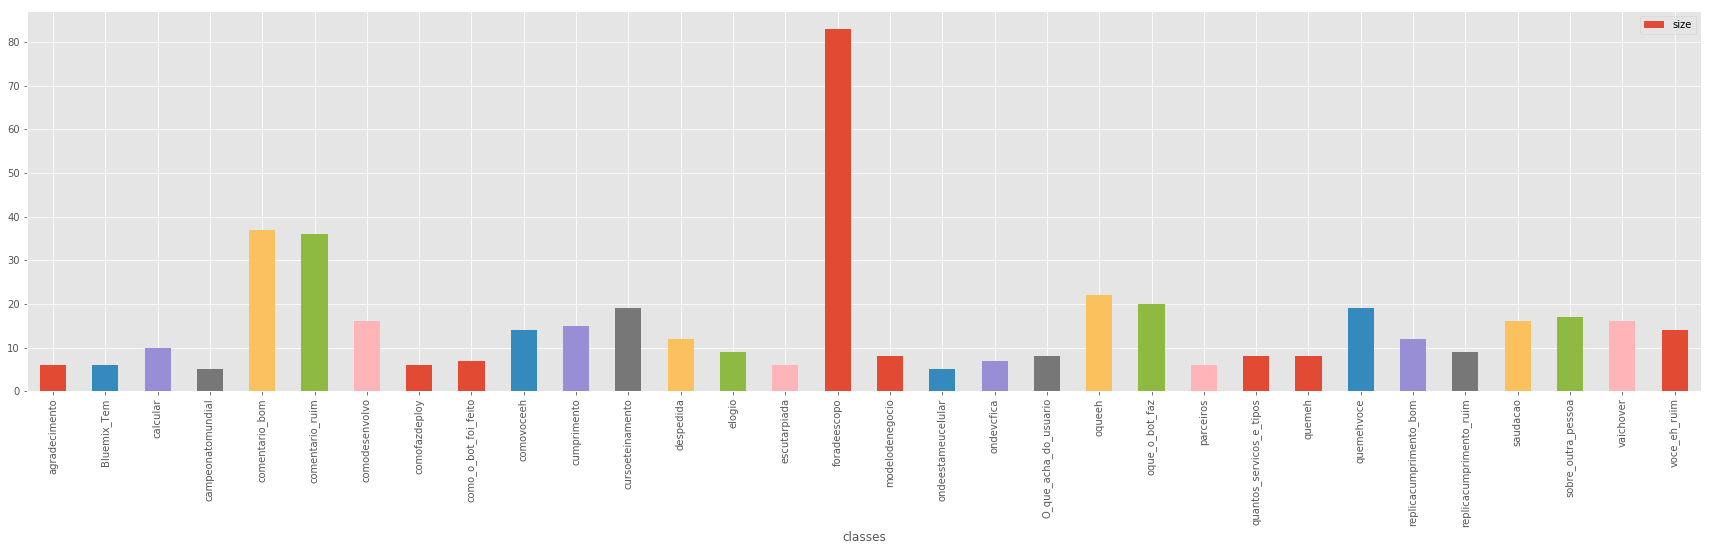

In [149]:
# Get list of intentions from the previous json export
list_original_intents = assistant.list_intents(
    workspace_id = original_workspace_id
) #.get_result()

list_original_examples = []
list_original_intent_names = []

# Variable declaration
intent_distribution = pd.DataFrame(columns=['classes', 'size'])
avg_size = 0;

# Assemble distribution view
for idx, intent in enumerate(list_original_intents['intents']):
    examples = assistant.list_examples(
    workspace_id = original_workspace_id,
    intent = list_original_intents['intents'][idx]['intent']
    ) #.get_result()
    avg_size = avg_size + len(examples['examples'])
    for example in examples['examples']:
        list_original_examples.append(example['text'])
        list_original_intent_names.append(list_original_intents['intents'][idx]['intent'])
        intent_distribution.loc[idx] = pd.Series({'classes':list_original_intents['intents'][idx]['intent'], 'size': len(examples['examples'])})
        #avg_size = avg_size + len(examples['examples'])

# Print the chart on the screen
intent_distribution.plot(kind='bar',x='classes', y='size',figsize=(30,7))

# Mount the data frame
intent_distribution = pd.DataFrame({
    'Example': list_original_examples,
    'Intent': list_original_intent_names
}, columns=['Example','Intent'])

In [150]:
# Mean size of intention
final_avg_size = avg_size/len(list_original_intents['intents'])

print("Average of instances by intention: " + str(final_avg_size))

Average of instances by intention: 15.0625


### Why concentrating examples on a single intent is not a good idea?
#### <a id="adtpa"></a>Unbalanced Samples and Accuracy Paradox

A common problem we encounter when working with data is related to the fact that the number of occurrences of a particular event is not generally balanced. In our case, people tend to train chatbots without considering the number of examples by intention and then they come across a bot that has many examples for one or two intentions and a bit for the rest...

In data science, we call this **unbalanced training sample** and its impact on the quality of our model happens because some distortions are created in relation to its lack of knowledge. Consider the following:

1. We have a training set with 90 positive examples and 10 negative examples.
2. The model is trained with it and assumes that each entry should be classified as positive.
3. **This is a bad model?**
4. **Not necessarily**, your classifier has 90% accuracy, which is very good!
5. **Is this helpful?** Probably not.

So this is called **accuracy paradox** (https://en.wikipedia.org/wiki/Accuracy_paradox), have a model that shows good metrics with a training sample, but this is not really useful. (You can learn more here: https://tryolabs.com/blog/2013/03/25/why-accuracy-alone-bad-measure-classification-tasks-and-what-we-can-do-about-it/)

You can also learn about unbalanced samples and how to treat them with these links:
* https://svds.com/learning-imbalanced-classes/ 
* https://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/

**So from what we've seen, it's good to keep your training sample with a similar amount of examples!** Let's see how our classifier is doing this.

In [151]:
# Coefficient of discrepancy
cte_coef_disc = 0.5

print(colored("\nIntentions with a discrepancy of examples (intent # examples):\n", attrs=['bold']))

if final_avg_size < 5:
    print(colored(">>> The sample presented does not meet the minimum required for training (5 examples) and, therefore, the deviations will not be calculated.", 'red', attrs=['bold']))
else:
    # Validation of which classes are "offending" the distribution
    for intent in list_original_intents['intents']:
        examples = assistant.list_examples(
        workspace_id = original_workspace_id,
        intent = intent['intent']
        ) #.get_result()

        diff = float(len(examples['examples'])) - final_avg_size
        if(abs(diff) > (final_avg_size * cte_coef_disc)):
            if diff > 0:
                printred("[+] >>> " + intent['intent'] + ' # ' + str(len(examples['examples'])) + ' / has ' + str(round(diff-(final_avg_size * cte_coef_disc),2)) + ' more examples than expected.',True)
            else:
                printred("[-] >>> " + intent['intent'] + ' # ' + str(len(examples['examples'])) + ' / has ' + str(round(abs(diff)-(final_avg_size * cte_coef_disc),2)) + ' fewer examples than expected.',True)
                    


Intentions with a discrepancy of examples (intent # examples):

[-] >>> agradecimento # 6 / has 1.53 fewer examples than expected.
[-] >>> Bluemix_Tem # 6 / has 1.53 fewer examples than expected.
[-] >>> campeonatomundial # 5 / has 2.53 fewer examples than expected.
[+] >>> comentario_bom # 37 / has 14.41 more examples than expected.
[+] >>> comentario_ruim # 36 / has 13.41 more examples than expected.
[-] >>> comofazdeploy # 6 / has 1.53 fewer examples than expected.
[-] >>> como_o_bot_foi_feito # 7 / has 0.53 fewer examples than expected.
[-] >>> escutarpiada # 6 / has 1.53 fewer examples than expected.
[+] >>> foradeescopo # 83 / has 60.41 more examples than expected.
[-] >>> ondeestameucelular # 5 / has 2.53 fewer examples than expected.
[-] >>> ondevcfica # 7 / has 0.53 fewer examples than expected.
[-] >>> parceiros # 6 / has 1.53 fewer examples than expected.


##### Feito! Agora temos uma primeira idéia de quais classes ajustar, a fim de tornar nosso classificador mais preciso, mas como podemos melhorar essa análise??

### <a id="intentmin"></a>Minimum of examples per intention
Another analysis we can do to ensure our best performance for chatbot is with respect to the minimum API requirements:

The Watson Assistant documentation mentions the **must have at least five examples per intention, but the suggestion is to reach up to ten examples**. Let's check if your chatbot meets these requirements:

In [152]:
print(colored("\nIntent without minimal amount of examples (5):\n", attrs=['bold']))

# Verifica se o mínimo exigido foi cumprido
for intent in list_original_intents['intents']:
    examples = assistant.list_examples(
    workspace_id = original_workspace_id,
    intent = intent['intent']
    ) #.get_result()

    if len(examples['examples']) < 5:
        printred(">>> " + intent['intent'] + ' # ' + str(len(examples['examples'])),True)
        
print(colored("\n\nIntention without minimum amount of examples SUGGESTED (10):\n", attrs=['bold']))

# Checks if the suggested minimum has been met
for intent in list_original_intents['intents']:
    examples = assistant.list_examples(
    workspace_id = original_workspace_id,
    intent = intent['intent']
    ) #.get_result()

    if len(examples['examples']) < 10:
        printred(">>> " + intent['intent'] + ' # ' + str(len(examples['examples'])),True)


Intent without minimal amount of examples (5):



Intention without minimum amount of examples SUGGESTED (10):

>>> agradecimento # 6
>>> Bluemix_Tem # 6
>>> campeonatomundial # 5
>>> comofazdeploy # 6
>>> como_o_bot_foi_feito # 7
>>> elogio # 9
>>> escutarpiada # 6
>>> modelodenegocio # 8
>>> ondeestameucelular # 5
>>> ondevcfica # 7
>>> O_que_acha_do_usuario # 8
>>> parceiros # 6
>>> quantos_servicos_e_tipos # 8
>>> quemeh # 8
>>> replicacumprimento_ruim # 9


**The intentions that appear above should be those you should focus on first because they do not even meet the minimum requirements. Should you question their existence, are they really necessary? If not, then do not put in your model, not even if you plan to use it in the future.**

### <a id="repeatedexamples"></a>Repeated examples
Our final analysis of examples of intention is related to repeated occurrences of it. Although not prohibited, having repeated examples in more than one intention is not a good practice..

In [153]:
print(colored("\nSelect repeated examples from our training set:\n", attrs=['bold']))

# Mounts example frequency
fdist = nltk.FreqDist(intent_distribution['Example'])        

# Select those with more than one occurrence
repeated = [x for idx,x in intent_distribution.sort_values("Example").iterrows() if x['Example'] in [k for k,v in fdist.items() if v > 1]]
for y in repeated:
    print(y['Example'] + ' # ' + y['Intent'])
    
if len(repeated) <= 2:
    print(colored("There are no repeated examples in our set. Congratulations!", 'green'))


Select repeated examples from our training set:

There are no repeated examples in our set. Congratulations!


## <a id="loganalysis"></a>Analysis of log history
Following our **data understanding** step of the process, we will now analyze our chatbot behavior with actual user input, the questions sent to our bot in the past.

Let's start by verifying the distribution of intention in our records, just as we did with our examples.

In [154]:
# Auxiliary function that calls WAS to log output
# By default it will bring 100 last interactions, so use the page_limit parameter
def mount_logs_dump(wid):
    response = assistant.list_logs(
    workspace_id = wid, page_limit = 200
    ) #.get_result()

    list_mount_examples = []
    list_mount_intents = []
    list_mount_intents2 = []
    list_mount_confidence = []
    list_mount_confidence2 = []
    
    cursor_regex = r".*?cursor=(.*?)&"

    while response and 'logs' in response:
    
        cont = 0
        for log in response['logs']:
            cont += 1
            if log["response"]:
                lresponse = log['response']
                
                if 'input' in lresponse and 'text' in lresponse['input']:
                    if 'intents' in lresponse and lresponse['intents']:
                        list_mount_examples.append(lresponse['input']['text'].strip())
                        list_mount_intents.append(lresponse['intents'][0]['intent'])
                        list_mount_confidence.append(lresponse['intents'][0]['confidence'])

                        if 'alternate_intents' in log['request'] and log['request']['alternate_intents'] == "true":
                            list_mount_intents2.append(lresponse['intents'][1]['intent'])
                            list_mount_confidence2.append(lresponse['intents'][1]['confidence'])
                        else:
                            list_mount_intents2.append('N/A')
                            list_mount_confidence2.append('0')
                    else:
                        list_mount_examples.append(lresponse['input']['text'].strip())
                        list_mount_intents.append('irrelevant')
                        list_mount_confidence.append('0')
                        list_mount_intents2.append('N/A')
                        list_mount_confidence2.append('0')
        
        if 'pagination' not in response or 'next_url' not in response['pagination']:
            #print(response)
            break
    
        cursor_res = re.search(cursor_regex, response['pagination']['next_url'], re.IGNORECASE)
        cursor = None
    
        if cursor_res:
            cursor = cursor_res.group(1)
        if not cursor:
            break
     
        response = assistant.list_logs(workspace_id=wid, page_limit=1000, cursor=cursor)
    
    df_temp = pd.DataFrame({
        'Example': list_mount_examples,
        'Intent_1': list_mount_intents,
        'Confidence_1': list_mount_confidence,
        'Intent_2': list_mount_intents2,
        'Confidence_2': list_mount_confidence2,
    }, columns=['Example','Intent_1','Confidence_1','Intent_2','Confidence_2'])
    
    return df_temp

In [155]:
# Gather logs of all conversations made in the workspace
list_logs = mount_logs_dump(original_workspace_id)

# Check for all logs
flag_logs = len(list_logs) > 0

In [156]:
# Mount our data frame for later viewing
if flag_logs:
    dist_logs = pd.DataFrame(columns=['intent', 'sizes','confidencesum'])

    # There is no need to analyze these
    intent_blacklist = ['greetings','fim']

    for idx,log in list_logs.iterrows():
        if log['Intent_1'] not in intent_blacklist:
            dist_logs.loc[idx] = pd.Series({'intent': log['Intent_1'], 'sizes': 1,'confidencesum': float(log['Confidence_1'])})

### <a id="meanconfidence"></a>General average of confidence

We could only look at the overall average confidence of our model over incoming user input (and this is a mistake that many people make). **But, like any metric or technique, we should think about what it currently represents.**

So let's imagine two different situations:

### Situation 1 - Inadequate distribution of tests
I have a chatbot with only a well-trained intention and all other intentions have a very bad training (remember the example of example unbalanced?). **We should have a bad trust number, right?** <font color='red'>**Not really**</font>

* If checked only with our log history and each entry was made against well-intentioned intent, then we would have a misleading confidence index with a high number. This does not represent the reality of our training.
* **Does that mean our bot is not good enough?** No. Actually, it answers what it needs most of the time, but gets lost with everything else. He does the just, he is not so smart.

**When does this usually happen?** We see this type of behavior when the same team creates and tests the bot. They know what the bot must respond to and are biased to restrict themselves within the limitations of the training. <font color='red'> **That is why you should test it with people who have not seen it before.** </font>

### Situation 2 - high confidence false positives
**This is more critical because it can lead to damage to the company image if this happens:**

we are talking about false positives, that is, when your bot returns high confidences for wrong intentions / answers. Imagine the same bot as before, but with the following result:
* Your users are asking many different questions for the remaining intentions (not the one with many examples) and always returns the same intent with high confidence (let's assume that each entry belongs to that class and returns with 85% confidence). **Too bad right?**
* Now imagine that the returned intention has the answer "It's always nice to talk to you" and the user wanted to complain or cancel. Or worse yet, the response comes as something aggressive to someone.


**This is a great example that shows us that using trust back without context can give you the opposite effect of the measurement ..**

In [157]:
# Calculates overall average confidence
if flag_logs:
    print("Average confidence (with irrelevant) > " + str(round(dist_logs['confidencesum'].mean()*100,2)) + " % ")
    print("Average confidence (without irrelevant) > " + str(round(dist_logs[dist_logs['intent'] != 'irrelevant']['confidencesum'].mean()*100,2)) + " % ")

Average confidence (with irrelevant) > 74.14 % 
Average confidence (without irrelevant) > 83.17 % 


**Então, vimos que a confiança média geral pode não ser uma boa demonstração do nível geral de precisão de nosso bot.**

### <a id="logdistribution"></a>Record distribution and average confidence by intention

Now that we've discussed what trust really means and the problems it could bring, we can do a smarter analysis of it using two graphs:
* Distribution of frequently asked questions.
* Average confidence by intention.

With this in hand, we can find the most frequently asked questions that have a lower confidence than expected and prioritize them.

**Good questions would be:**
* Do our main intentions reach a minimum level defined by us?
* What intention should I focus on first?
* For those with less than the minimum: Do we have enough new inputs to improve training?



More asked intentions with more than 5 samples



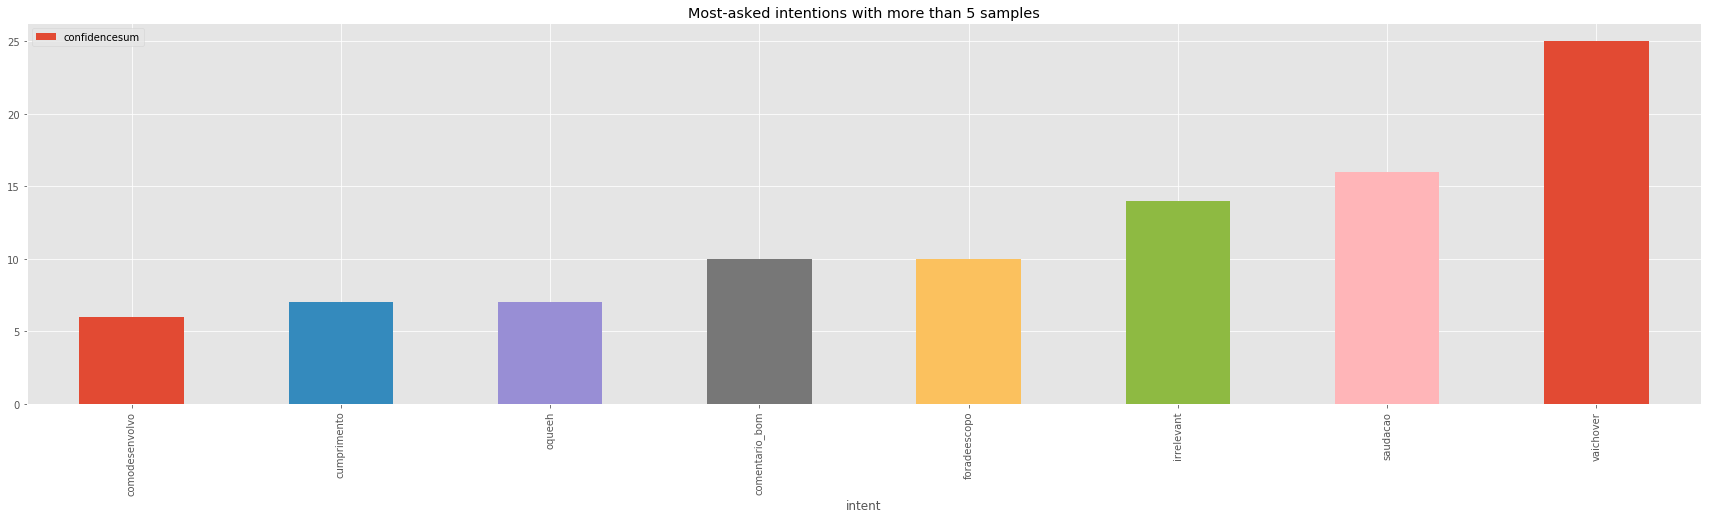

In [159]:
# Group intentions, sum events, and calculate the average confidence for each.
if flag_logs:
    
    # Groups of intentions
    grouped1 = dist_logs.groupby('intent').mean()
    grouped2 = dist_logs.groupby('intent').count()
    
    cte_logs = 5

    print(colored('More asked intentions with more than ' + str(cte_logs) + ' samples\n', attrs=['bold']))
    grouped4 = grouped2.where(lambda x : x['sizes'] > cte_logs).dropna().sort_values(by='sizes')
    
    grouped4.index.name='intent'
    grouped4['intent']=grouped4.index
    
    # Displays the distribution log on the screen
    grouped4.plot(kind='bar',x='intent', y='confidencesum',figsize=(30,7),title='Most-asked intentions with more than ' + str(cte_logs) + ' samples')

In [160]:
if flag_logs:
    # Calculates the intersection between series
    df_intersection = pd.merge(grouped4, grouped1, left_index=True, right_index=True)
    df_intersection.drop('confidencesum_x', axis=1, inplace=True)
    
    print(colored('Average confidence by intention (with more than ' + str(cte_logs) + ' samples):\n', attrs=['bold']))
    display(df_intersection.sort_values(by='confidencesum_y'))

Average confidence by intention (with more than 5 samples):



,sizes,intent,confidencesum_y
intent,,,
irrelevant,14.0,irrelevant,0.000000
comentario_bom,10.0,comentario_bom,0.668001
cumprimento,7.0,cumprimento,0.730411
oqueeh,7.0,oqueeh,0.762572
foradeescopo,10.0,foradeescopo,0.769510
comodesenvolvo,6.0,comodesenvolvo,0.780464
vaichover,25.0,vaichover,0.937277
saudacao,16.0,saudacao,0.951995


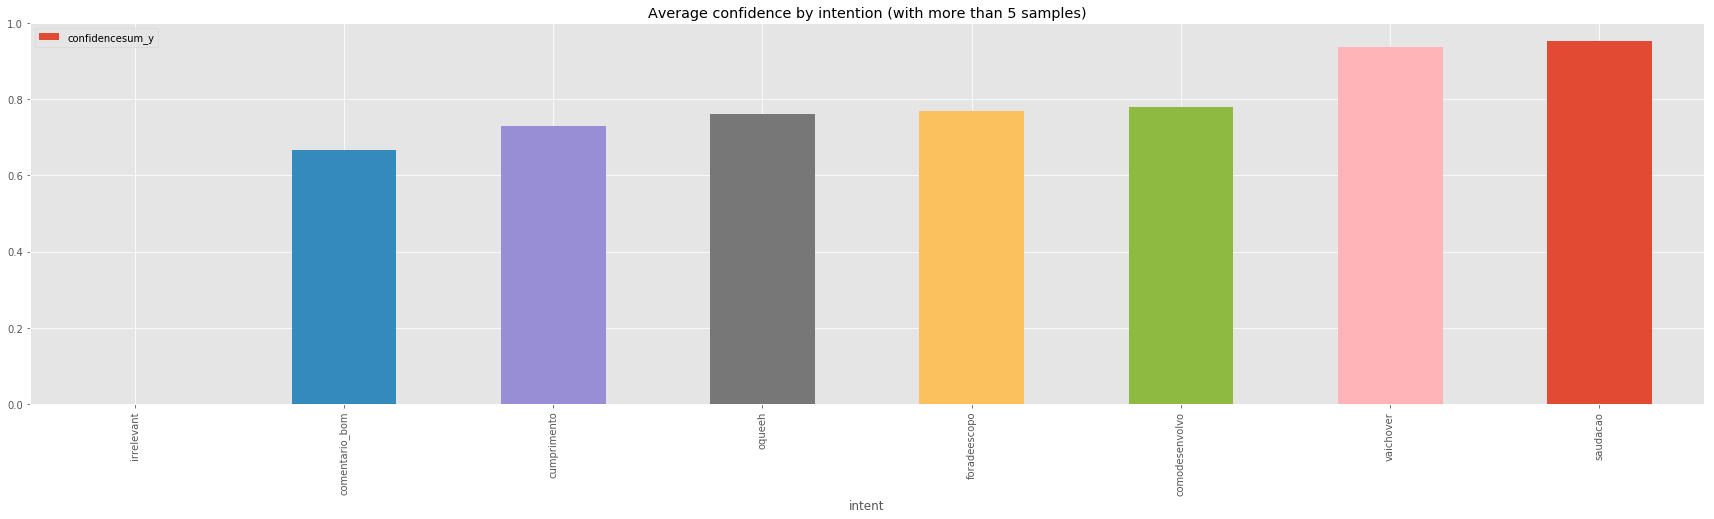

In [161]:
# Prints graph with log distribution vs. general confidence

if flag_logs:
    df_intersection.sort_values(by='confidencesum_y').plot(kind='bar',x='intent', y='confidencesum_y',figsize=(30,7),title='Average confidence by intention (with more than ' + str(cte_logs) + ' samples)')

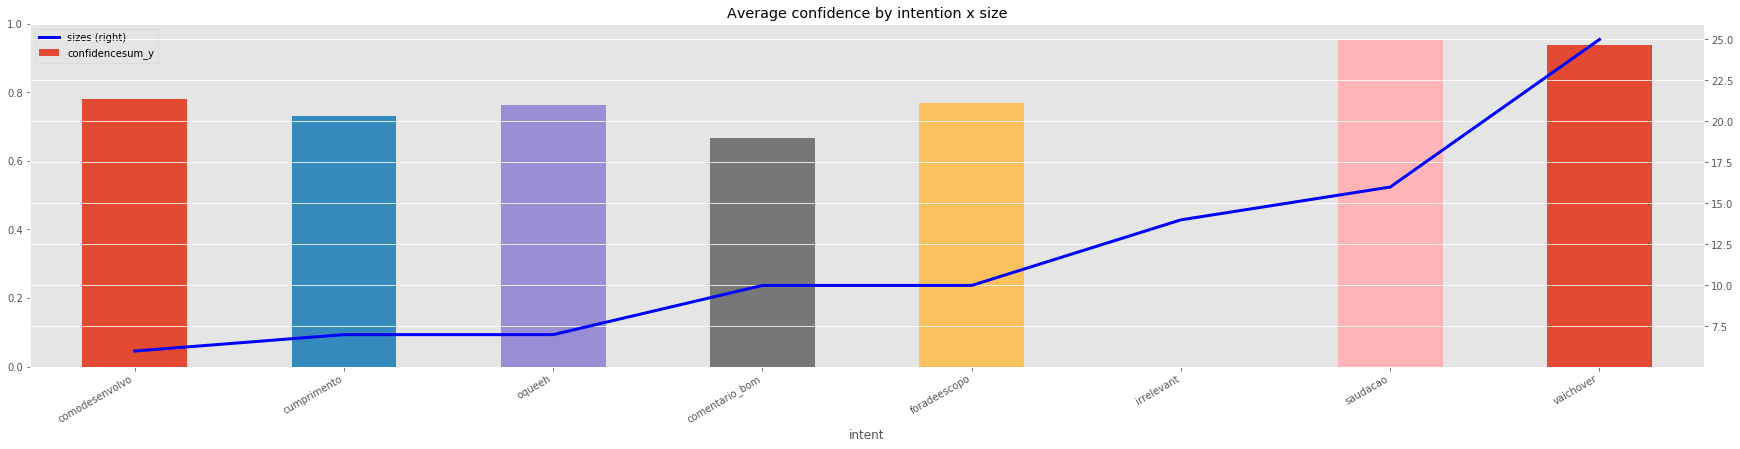

In [162]:
# Print mixed graphics
if flag_logs:
    # Removes unnecessary columns
    grouped4.drop('confidencesum', axis=1, inplace=True)
    df_intersection.drop('sizes', axis=1, inplace=True)

    ax = grouped4.plot(kind='line',x='intent', y='sizes',figsize=(30,7),color='b',linewidth=3,secondary_y=True,legend=True)
    df_intersection.plot(ax=ax, kind='bar',x='intent', y='confidencesum_y',figsize=(30,7),title='Average confidence by intention x size',legend=True)
    
    plt.gcf().autofmt_xdate()
    plt.show()

### (Understanding the graph above)
A good approach here would be to set a minimum threshold for the expected trust, and then begin to analyze intention by intention from right to left.

### <a id="lowconfidence"></a>Examples with low confidence

Depending on the amount of interactions your bot already had to start a retreine can seem like a daunting task. A good practice is to start your Assistant's retreine using those examples that have a very low confidence level, these interactions will serve to make you see the need to create new intentions and / or add more examples to existing intentions, remembering that these examples will have more impact on training than those with a high level of confidence.

In [163]:
MIN_CONFIDENCE = 0.5

if flag_logs:
    counter = 0
    arr_inputs = []
    arr_intents = []
    arr_confidence = []
    arr_repeated = []

    for idx,log in list_logs.iterrows():
        current_intent = log['Intent_1']

        if current_intent not in intent_blacklist and float(log['Confidence_1']) < MIN_CONFIDENCE:
            arr_repeated.append(log['Example'])

            if float(log['Confidence_1']) < MIN_CONFIDENCE and log['Example'] not in arr_inputs:
                counter = counter + 1
                arr_inputs.append(log['Example'])
                arr_intents.append(log['Intent_1'])
                arr_confidence.append(log['Confidence_1'])
    
    low_confidence = pd.DataFrame({
        'Example': arr_inputs,
        'Intent': arr_intents,
        'Confidence': arr_confidence,
    }, columns=['Example','Intent','Confidence'])

    print(display(arr_inputs[0:20]))

['Você acredita que o mundo será controlado por IA?',
 'microsoft or google?',
 'Oiiii',
 'Manaus, Amazonas',
 'sorry',
 'mande-me como você nasceu',
 'Alguém usou Azure IoT com Nó Vermelho?',
 'Conhece ?',
 'Sim',
 'Conhece rancho queimado ?',
 'Poxa',
 'O que fazer',
 'Meu deus',
 'Tutupom',
 'O que mais?',
 'o que é C#',
 'É gratuito?',
 'whatsapp',
 'tô triste',
 'o que é bluemox']

None


### <a id="manyquestions"></a>Frequently Asked Questions

Another good starting point for training your chatbot may be those questions asked more than once without a good level of confidence returned.

In [164]:
if flag_logs:
    print(colored("\nIt selects the examples with greater occurrence (more than 2 repetitions) and less confidence:\n", attrs=['bold']))

    fdist = nltk.FreqDist(arr_repeated)
    flag = False

    for k,v in sorted(fdist.items(), key=lambda t:t[-1], reverse=True):
        if v > 2:
            flag = True
            print("[" + str(v) + "] > ",k)
    if flag is False:
        print("No repeated logs were found.")


It selects the examples with greater occurrence (more than 2 repetitions) and less confidence:

No repeated logs were found.


## <a id="advanced"></a>Step 4 - ** Advanced Analysis **

So that we can analyze the quality of our chatbot with a little more depth we need to know some concepts before:

First we have to keep in mind that the task of identifying in which class (intention) an input (example) belongs is a task of statistical classification(https://en.wikipedia.org/wiki/Statistical_classification) and therefore we must use specific methods to evaluate this type of task.

Still on concepts, consider the problem of verifying that an input belongs to the intention #resetPassword:
* **True positive (TP)** or True Positive (VP): cases where we returned the correct class, the model predicted that the class was #resetarSenha.
* **False positives (FP** or False positives (FP): cases in which we returned saying that it was the class #resetPassword when in fact it was another.
* **True Negative (TN)** or True False (PV): cases that we returned that was another class and really were.
* **False Negative (FN)** or False Negatives (FN): we returned that was another class when in fact it was #resetPassword.
* **Matrix of Confusion**: brings a visual analysis of the concepts presented above.

**All of these concepts are best explored on the following links:**
* https://medium.com/as-m%C3%A1quinas-que-pensam/m%C3%A9tricas-comuns-em-machine-learning-como-analisar-a-qualidade-de-chat-bots-inteligentes-introdu-57ff30424192
* https://medium.com/as-m%C3%A1quinas-que-pensam/m%C3%A9tricas-comuns-em-machine-learning-como-analisar-a-qualidade-de-chatbots-inteligentes-conceitos-a5b586053973
* https://medium.com/as-m%C3%A1quinas-que-pensam/m%C3%A9tricas-comuns-em-machine-learning-como-analisar-a-qualidade-de-chat-bots-inteligentes-m%C3%A9tricas-1ba580d7cc96

**Note: for cost reasons we will do a simpler analysis based on sampling, at the end of this notebook we will cover other methods that can be used to measure your chatbot with even more precision.**
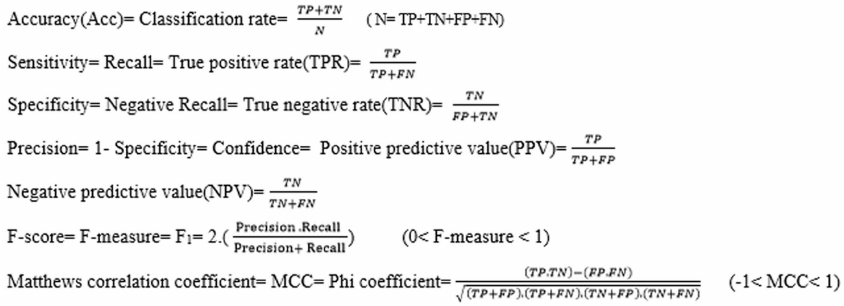

In [165]:
# Mounts the dataframe to be worked with
le_examples = []
le_intents = []

for intent in list_original_intents['intents']:
    examples = assistant.list_examples(
    workspace_id = original_workspace_id,
    intent = intent['intent']
    ) #.get_result()
        
    for ex in examples['examples']:
        le_examples.append(ex['text'])
        le_intents.append(intent['intent'])
        
list_ml_examples = pd.DataFrame({
    'Example': le_examples,
    'Intent': le_intents,
}, columns=['Example','Intent'])

#### <a id="amostragem"></a>Sampling

As mentioned above we will test our bot based on sampling and for this we need to separate the datasets between training and test respecting a pre-determined ratio of 80/20, and the training set will be the one that we will effectively use to train a new model and the test set we will use to submit to the new template created and verify that the result is the same as expected.

Note: this method does not work as well when we have a very small sample because the trained model will have few inputs with which to learn.

In [167]:
# Because we need to submit some examples to test the template, this task can generate costs if you have already exceeded 10,000 free monthly requests.
length_test_set = len(list_ml_examples)*0.2*3
print("Exemplos: "+ str(len(list_ml_examples)*0.2*3))

print(colored('TTENTION! When you run this test, you may be charged up to US$ ' + str(round(length_test_set*0.0025,2)) + '. Those costs are associated with ' 
              + str(round(length_test_set)) + ' calls to be made to your workspace! Enter OK to accept...','red', attrs=['bold']))

acceptance = input()

if acceptance == 'OK'or acceptance == 'Ok'or acceptance == 'ok':
    print("OK! Let's continue...")

Exemplos: 289.20000000000005
TTENTION! When you run this test, you may be charged up to US$ 0.72. Those costs are associated with 289 calls to be made to your workspace! Enter OK to accept...
ok
OK! Let's continue...


In [168]:
# An auxiliary function that groups intentions together and assembles an array that the WAS can understand. It also validates the number of examples in each intent.
def group_and_mount_intents(train_set):
    
    intents = {}
    
    # Groups of intentions
    for idx, example in train_set.iterrows():
        current_intent = example['Intent']
        
        if current_intent not in intents: 
            intents[current_intent] = []

        intents[current_intent].append(example['Example'])
        

    workspace_intens = []
    
    # Transforms the format of intent into what is accepted by the WAS
    for intent, examples in intents.items():
        entry = {'intent': intent, 'examples': []}
        if len(examples) < 10:
            print("[ATTENTION] Intent #" + intent + " has few examples [" + str(len(examples)) + "] than expected, and therefore is not a good example for this test..")

        for example in examples:
            entry['examples'].append({ 'text': example })

        workspace_intens.append(entry)

    print('\nIntentions mounted.')

    return workspace_intens

In [169]:
# Auxiliary function that creates a new workspace to run tests without damaging the current chatbot
def create_test_workspace(train_set):
    intents_json = group_and_mount_intents(train_set)
    
    entities_list = assistant.list_entities(
        workspace_id = original_workspace_id
    ) #.get_result()    
    
    response = assistant.create_workspace(name = 'Create_by_Watson_Studio', entities = entities_list['entities'], intents = intents_json, language = 'pt-br')

    print('Skill replicated, wait to be ready...')
        
    #print(response.result["workspace_id"])
    print(response)

    #check_wksp_status(response.result["workspace_id"])

    check_wksp_status(response["workspace_id"])
    
    return response["workspace_id"]

In [170]:
def mount_confusion_matrix(test_set,teste_wid):
    cm_predicted = []
    cm_predicted_2 = []

    cm_conf_p1 = []
    cm_conf_p2 = []
    cm_delta = []

    cm_true = []
    cm_true_q = []
    
    for index, row in test_set.iterrows():
        message = { 'text': row['Example'] }
        
        response = assistant.message(workspace_id=teste_wid,input=message,alternate_intents=True) #.get_result()

        if response['intents'] != []:
            cm_true_q.append(row['Example'])
            cm_true.append(row['Intent'])
            cm_predicted.append(response['intents'][0]['intent'])
            cm_conf_p1.append(response['intents'][0]['confidence'])

            if len(response['intents']) > 1:
                cm_predicted_2.append(response['intents'][1]['intent'])
                cm_conf_p2.append(response['intents'][1]['confidence'])
                cm_delta.append(float(response['intents'][0]['confidence']) - float(response['intents'][1]['confidence']))
            else:
                cm_predicted_2.append('irrelevant')
                cm_conf_p2.append(0)
                cm_delta.append(1)
    
    resultados = pd.DataFrame({
        'Question': cm_true_q,
        'True': cm_true,
        'Predicted_1': cm_predicted,
        'Predicted_2': cm_predicted_2,
        'Conf_1': cm_conf_p1,
        'Conf_2': cm_conf_p2,
        'Delta': cm_delta
    }, columns=['Question','True','Predicted_1','Predicted_2','Conf_1','Conf_2','Delta','Missed'])

    resultados['Missed'] = resultados.apply(lambda x : 'X' if x['True'] != x['Predicted_1'] else '', axis=1)
    
    return resultados, cm_true, cm_predicted, cm_predicted_2

In [171]:
def plot_confusion_matrix(cm, classes=None, normalize=False, title='', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Matrix of confusion, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## ML Execution Results

As a sampling strategy, we run an 80/20 split three times and then calculate the resulting scores. If executed only when its results are unreliable due to the dependence on the random selection of the sample, we will do this at least three times to reduce the error.

In [172]:
N_ROUNDS = 1
run_wids = []
run_total_df_result = pd.DataFrame(columns=['Question','True','Predicted_1','Predicted_2','Conf_1','Conf_2','Delta','Missed'])
run_total_true = []
run_total_predicted = []
run_total_predicted_2 = []

for run_counter in range(0,N_ROUNDS):
    
    # Divide the training and test sets with a ratio of 80/20
    X_train, X_test, y_train, y_test = train_test_split(list_ml_examples, list_ml_examples.Intent, test_size=0.2, stratify=list_ml_examples.Intent)
    
    # Create Skill for test
    test_wid = create_test_workspace(X_train)
    
    run_temp_result, run_temp_true, run_temp_predicted, run_temp_predicted_2 = mount_confusion_matrix(X_test,test_wid)
    
    run_wids.append(test_wid)
    run_total_df_result = pd.concat([run_total_df_result,run_temp_result])
    run_total_true = run_total_true + run_temp_true
    run_total_predicted = run_total_predicted + run_temp_predicted
    run_total_predicted_2 = run_total_predicted + run_temp_predicted_2
    
    run_counter = run_counter + 1
    
    # Automatically deletes the Skill / Workspace created for testing
    assistant.delete_workspace(workspace_id=test_wid)


[ATTENTION] Intent #modelodenegocio has few examples [6] than expected, and therefore is not a good example for this test..
[ATTENTION] Intent #escutarpiada has few examples [5] than expected, and therefore is not a good example for this test..
[ATTENTION] Intent #elogio has few examples [7] than expected, and therefore is not a good example for this test..
[ATTENTION] Intent #campeonatomundial has few examples [4] than expected, and therefore is not a good example for this test..
[ATTENTION] Intent #comofazdeploy has few examples [5] than expected, and therefore is not a good example for this test..
[ATTENTION] Intent #O_que_acha_do_usuario has few examples [6] than expected, and therefore is not a good example for this test..
[ATTENTION] Intent #quemeh has few examples [6] than expected, and therefore is not a good example for this test..
[ATTENTION] Intent #Bluemix_Tem has few examples [5] than expected, and therefore is not a good example for this test..
[ATTENTION] Intent #calcula

In [173]:
class_names = run_total_df_result['True'].drop_duplicates().tolist()
class_names.append('irrelevant')

figure_size = (50,50)
mpl.rcParams['figure.figsize'] = figure_size

### Matrix of Confusion

To understand a matrix of confusion (cm), you must understand that for each class x:
* True positives: diagonal position, cm (x, x).
* False positives: sum of column x (without main diagonal), sum (cm (: x)) - cm (x, x).
* False negatives: sum of line x (without main diagonal), sum (cm (x, :), 2) - cm (x, x).

Matrix of confusion, without normalization


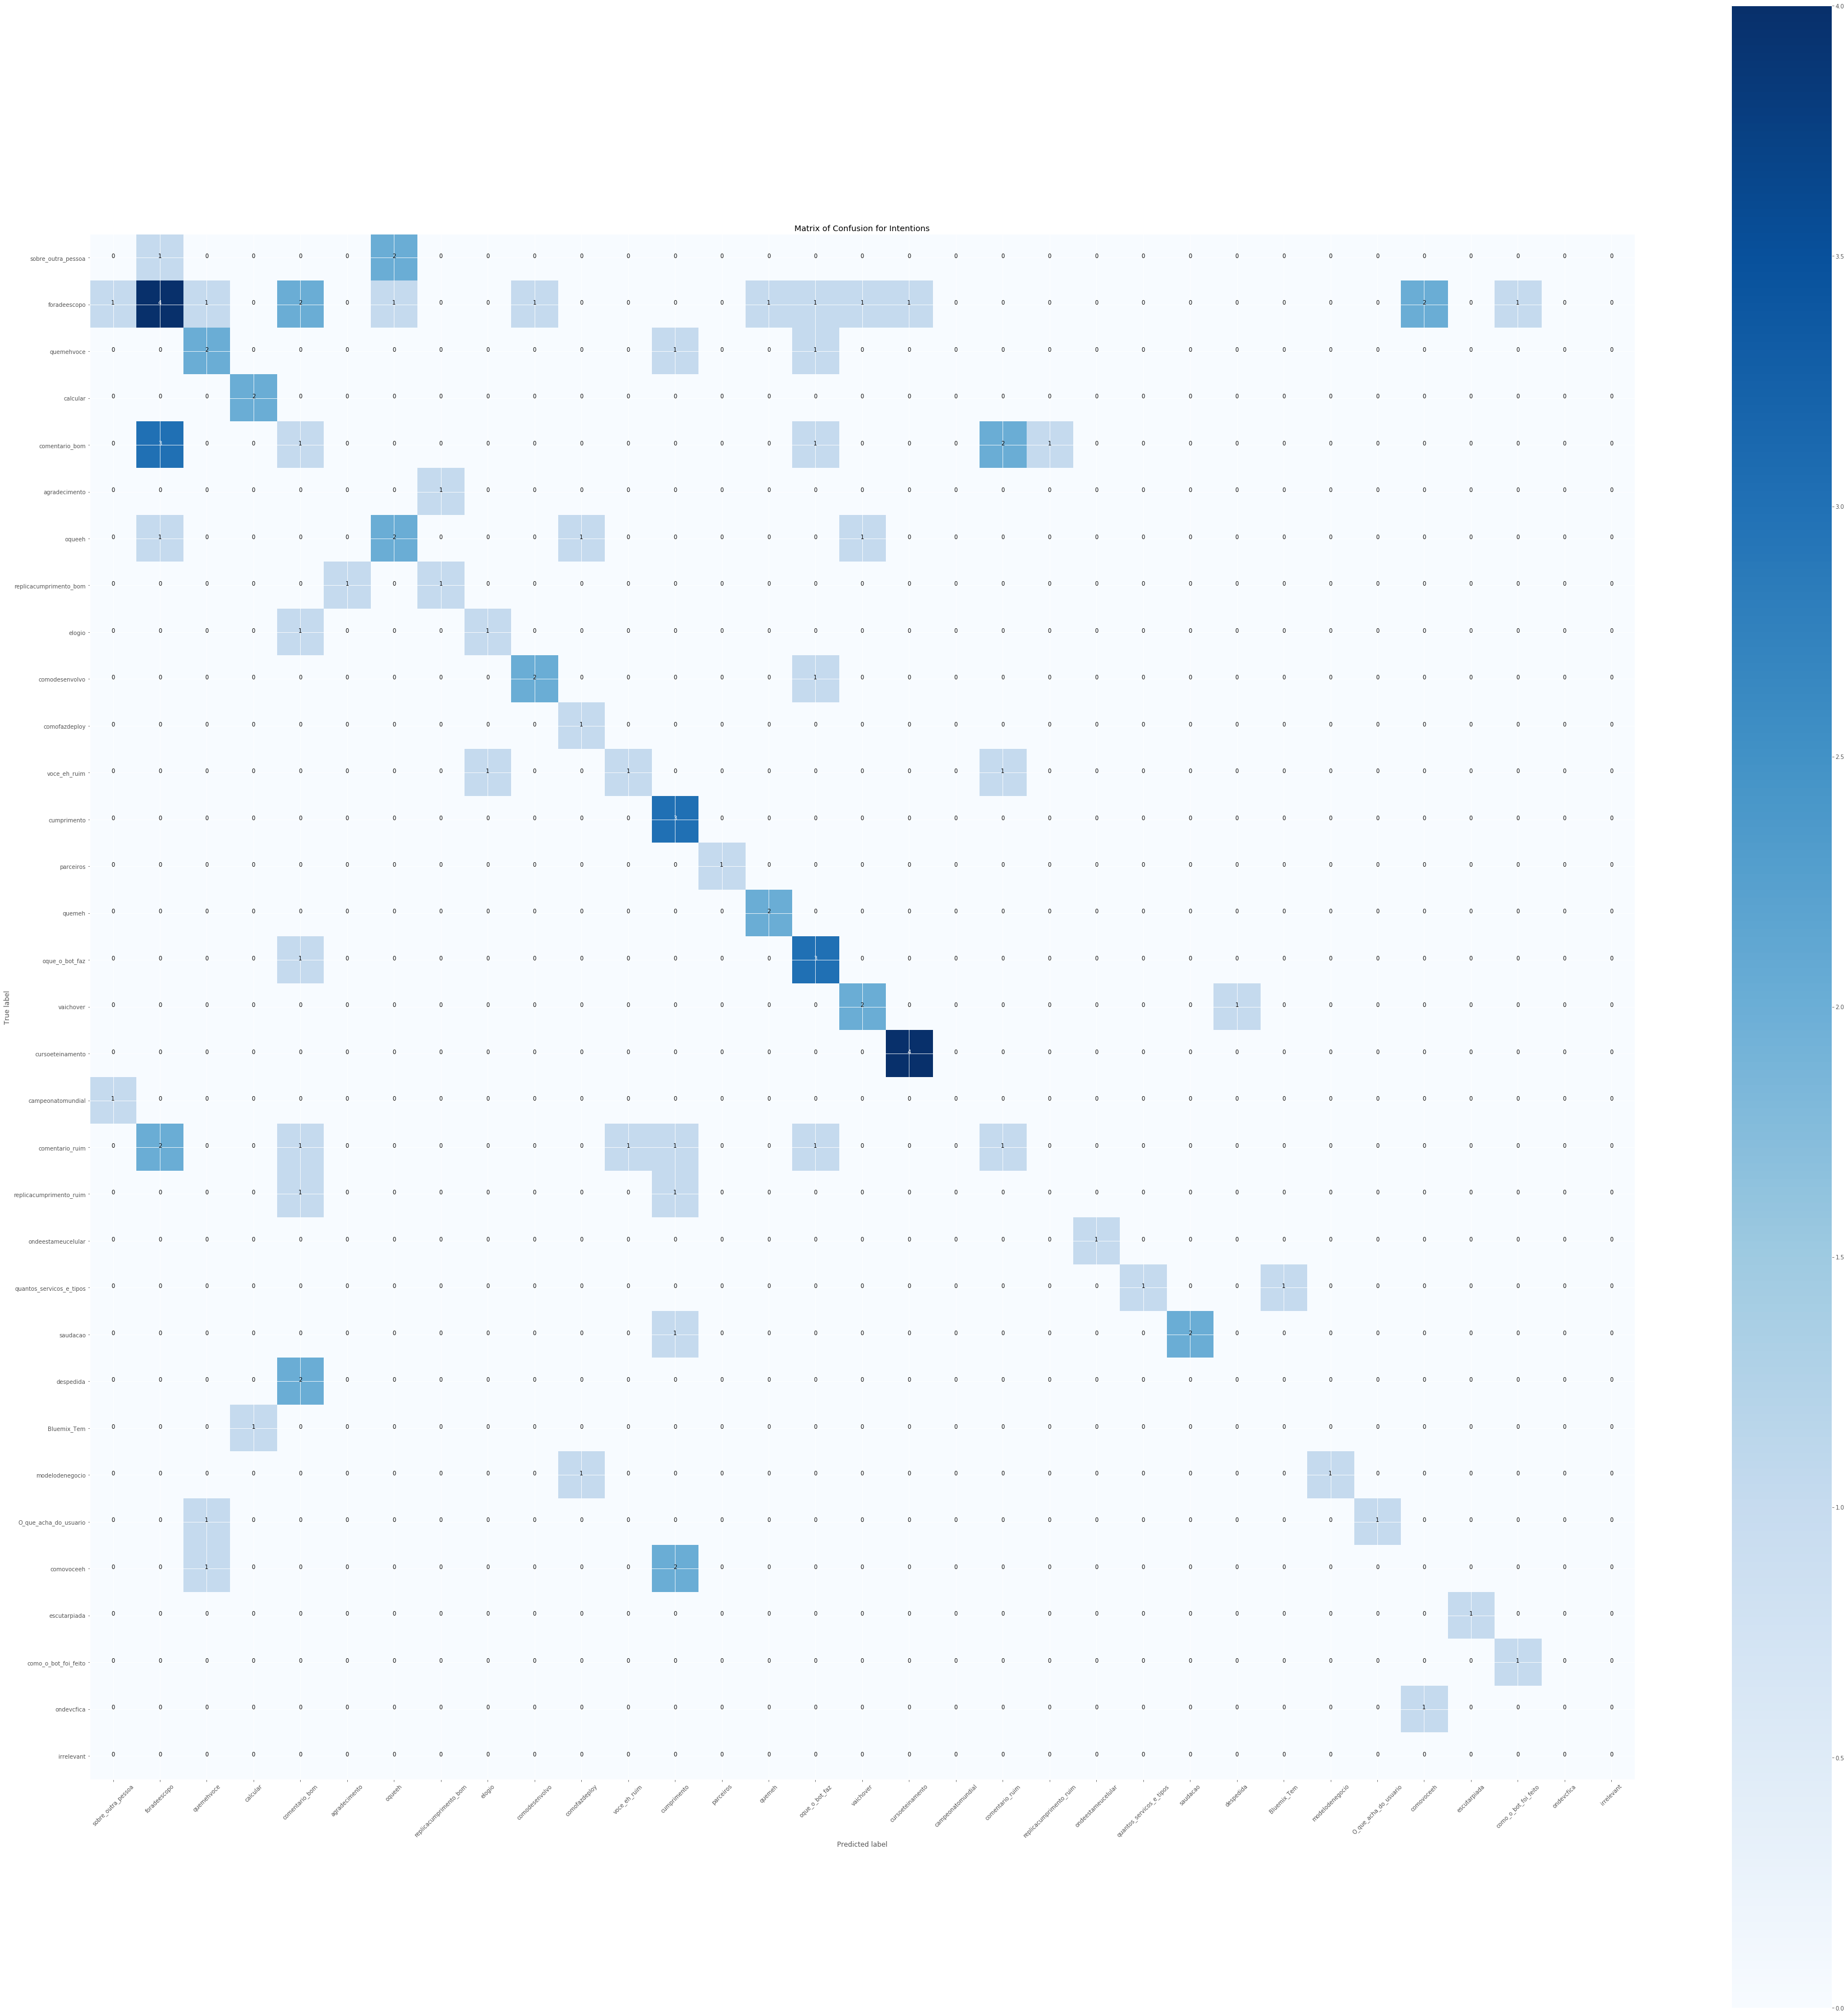

In [174]:
cnf_matrix = confusion_matrix(run_total_true, run_total_predicted, labels=class_names)
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Matrix of Confusion for Intentions')

In [175]:
print("Precision")
print("Weighted: " + str(precision_score(run_total_true, run_total_predicted, average='weighted')))

print("\n\nRecall")
print("Weighted: " + str(recall_score(run_total_true, run_total_predicted, average='weighted')))

print("\n\nF1")
print("Weighted: " + str(f1_score(run_total_true, run_total_predicted, average='weighted')))


Precision
Weighted: 0.418770175987


Recall
Weighted: 0.422680412371


F1
Weighted: 0.39778693108


/gpfs/fs01/user/scb4-547fcd10f85a8a-6a9412c8378f/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/gpfs/fs01/user/scb4-547fcd10f85a8a-6a9412c8378f/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [176]:
# Metrics for each intent
print(classification_report(run_total_true, run_total_predicted))

                          precision    recall  f1-score   support

             Bluemix_Tem       0.00      0.00      0.00         1
   O_que_acha_do_usuario       1.00      0.50      0.67         2
           agradecimento       0.00      0.00      0.00         1
                calcular       0.67      1.00      0.80         2
       campeonatomundial       0.00      0.00      0.00         1
          comentario_bom       0.11      0.12      0.12         8
         comentario_ruim       0.25      0.14      0.18         7
    como_o_bot_foi_feito       0.50      1.00      0.67         1
          comodesenvolvo       0.67      0.67      0.67         3
           comofazdeploy       0.33      1.00      0.50         1
              comovoceeh       0.00      0.00      0.00         3
             cumprimento       0.33      1.00      0.50         3
        cursoeteinamento       0.80      1.00      0.89         4
               despedida       0.00      0.00      0.00         2
         

/gpfs/fs01/user/scb4-547fcd10f85a8a-6a9412c8378f/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
